In [1]:
#Importing the libraries needed into Python
import pandas            as pd                       # data science essentials
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree                   # tree plots
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier #for hyperparameter tuning


#Loading the data from excel into Python
file = "./GOT_character_predictions.xlsx"

#Reading the file 
got = pd.read_excel(io = file)

#Panda Print Options are set
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

#Printing the results
got.head(n = 10)

,S.No,name,title,male,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveFather,isAliveMother,isAliveSpouse,isAliveHeir,age,popularity,isAlive
0,1,Erreg,King,0,Andal,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0.016722,1
1,2,Hugor of the Hill,King of the Andals,1,Andals,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0.050167,1
2,3,Azor Ahai,NaN,0,Asshai,NaN,NaN,NaN,NaN,NaN,Nissa Nissa,0,1,1,1,1,NaN,NaN,NaN,1.0,NaN,0.117057,1
3,4,Melisandre,NaN,0,Asshai,NaN,NaN,NaN,NaN,R'hllor,NaN,0,1,1,1,1,NaN,NaN,NaN,NaN,NaN,0.745819,1
4,5,Kraznys mo Nakloz,NaN,1,Astapor,NaN,NaN,NaN,NaN,Good Masters,NaN,0,0,1,0,1,NaN,NaN,NaN,NaN,64.0,0.076923,0
5,6,Grazdan mo Ullhor,Good Master,1,Astapori,NaN,NaN,NaN,NaN,Good Masters,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0.030100,0
6,7,Cleon,King of Astapor,1,Astapori,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,0.103679,0
7,8,Ghael,Lord,1,Astapori,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,0.023411,1
8,9,Grazdan,Good Master,1,Astapori,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0.013378,0
9,10,Moonshadow,NaN,0,Braavos,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,NaN,NaN,NaN,NaN,50.0,0.010033,1


In [2]:
#This is for the missing values
def mv_flagger(df):
    """
Flags all columns that have missing values with 'm-COLUMN_NAME'.

PARAMETERS
----------
df : DataFrame to flag missing values


RETURNS
-------
DataFrame with missing value flags."""

#Creating data frame for missing values
    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df #Returns dataframe



#Defining text split for missing values
def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    #Setting new column name to 0
    df[new_col_name] = 0
    
    #This will loop through each row
    for index, val in df.iterrows(): 
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))

In [3]:
#Loading in the User Defined Functions needed
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.10, #Test size
                      seed=219, #Sample size
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
#Information on the parameters
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
x_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the x data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
#This is executed if the condition is true   
    if standardize == True: 
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df #Stores it in this dataframe



    #Creating the train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    #Lists are created for the train/test
    training_accuracy = []
    test_accuracy = []
    
    
    #Creating a range for neighbors
    neighbors_settings = range(1, max_neighbors + 1)

    #Model is based on the Y variable
    for n_neighbors in neighbors_settings:
        if response_type == 'reg': #If this condition is true then run this
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class': #Else if condition 
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else: #Else condition
            print("Error: response_type must be 'reg' or 'class'")
        
        
        #Training accruacy is recored
        training_accuracy.append(clf.score(x_train, y_train))
        
        #Testing accuracy is records
        test_accuracy.append(clf.score(x_test, y_test))

    #Creating needed visualizations
    if show_viz == True:
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy") #For training
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy") #For testing
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    #Printing the optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


#User defined function for visual
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    #Creating labels for confusion matrix
    lbls = labels
    

    #Confusion matrix variables
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    #Visualization for confusion matrix
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

In [4]:
#Pulling in the data dictionary from excel
got_description = pd.read_excel('./GOT_data_dictionary.xlsx')

#Looking at results
got_description

,S.No,Character number (by order of appearance)
0,name,Character name
1,title,Honorary title(s) given to each character
2,male,"1 = male, 0 = female"
3,culture,Indicates the cultural group of a character
4,dateOfBirth,Known dates of birth for each character (measurement unknown)
5,mother,Character's biological mother
6,father,Character's biological father
7,heir,Character's biological heir
8,house,Indicates a character's allegiance to a house (i.e. a powerful family)
9,spouse,Character's spouse(s)


Assumptions:
1-The Y variable must be binary since it is a classification model
2-Male,book1_A_Game_Of_Thrones, book2_A_Clash_Of_Kings, book3_A_Storm_Of_Swords, 
book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons can't be the Y-variable. 
3-This can't be based on whether or not they appeared in the book or gender
4--Looking through the columns and data, we are trying to find out whether a character is alive or not
5-isAlive can be influenced by other variables such as name, title, and more


From these assumptions, isAlive is considered the Y-variable.

In [5]:
#Looking at the data to understand what the response variable (Y-variable is)
got.head(n = 10)

,S.No,name,title,male,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveFather,isAliveMother,isAliveSpouse,isAliveHeir,age,popularity,isAlive
0,1,Erreg,King,0,Andal,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0.016722,1
1,2,Hugor of the Hill,King of the Andals,1,Andals,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0.050167,1
2,3,Azor Ahai,NaN,0,Asshai,NaN,NaN,NaN,NaN,NaN,Nissa Nissa,0,1,1,1,1,NaN,NaN,NaN,1.0,NaN,0.117057,1
3,4,Melisandre,NaN,0,Asshai,NaN,NaN,NaN,NaN,R'hllor,NaN,0,1,1,1,1,NaN,NaN,NaN,NaN,NaN,0.745819,1
4,5,Kraznys mo Nakloz,NaN,1,Astapor,NaN,NaN,NaN,NaN,Good Masters,NaN,0,0,1,0,1,NaN,NaN,NaN,NaN,64.0,0.076923,0
5,6,Grazdan mo Ullhor,Good Master,1,Astapori,NaN,NaN,NaN,NaN,Good Masters,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0.030100,0
6,7,Cleon,King of Astapor,1,Astapori,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1,NaN,NaN,NaN,NaN,NaN,0.103679,0
7,8,Ghael,Lord,1,Astapori,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,0.023411,1
8,9,Grazdan,Good Master,1,Astapori,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0.013378,0
9,10,Moonshadow,NaN,0,Braavos,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,NaN,NaN,NaN,NaN,50.0,0.010033,1


dateOfBirth looks as though it appears before and after the event horizon. 
There are a lot of null values for it too.

In [6]:
got.isnull().sum(axis = 0)

S.No                             0
name                             0
title                          956
male                             0
culture                       1209
dateOfBirth                   1445
mother                        1815
father                        1810
heir                          1813
house                          414
spouse                        1580
book1_A_Game_Of_Thrones          0
book2_A_Clash_Of_Kings           0
book3_A_Storm_Of_Swords          0
book4_A_Feast_For_Crows          0
book5_A_Dance_with_Dragons       0
isAliveFather                 1815
isAliveMother                 1810
isAliveSpouse                 1813
isAliveHeir                   1580
age                           1426
popularity                       0
isAlive                          0
dtype: int64

In [7]:
#Dropping dateofBirth from columns since it is outside the event horizon
#Age is odd without feature engineering
got = got.drop(['dateOfBirth',
                'age'
                ],
                axis   = 1)

#Only run code once to avoid errors

# checking results
got.columns

Index(['S.No', 'name', 'title', 'male', 'culture', 'mother', 'father', 'heir', 'house', 'spouse', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveFather', 'isAliveMother', 'isAliveSpouse', 'isAliveHeir', 'popularity', 'isAlive'], dtype='object')

In [8]:
#Missing variables will get flagged
got = mv_flagger(df = got)

#Printign results
got.columns

Index(['S.No', 'name', 'title', 'male', 'culture', 'mother', 'father', 'heir', 'house', 'spouse', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveFather', 'isAliveMother', 'isAliveSpouse', 'isAliveHeir', 'popularity', 'isAlive', 'm_title', 'm_culture', 'm_mother', 'm_father', 'm_heir', 'm_house', 'm_spouse', 'm_isAliveFather', 'm_isAliveMother', 'm_isAliveSpouse', 'm_isAliveHeir'], dtype='object')

In [9]:
# imputing missing values
got['title'] = got['title'].fillna('Unknown')

got['culture'] = got['culture'].fillna('Unknown')

got['house'] = got['culture'].fillna('Unknown')


In [10]:
#Creating text_split_feature based off of name
text_split_feature(col = 'name',
                   df  = got)


#Printing results
got['number_of_names'].value_counts(normalize = False,
                                        sort      = False,
                                        ascending = False).sort_index()

1     560
2    1128
3      92
4       9
5      35
6      12
Name: number_of_names, dtype: int64

In [11]:
#Relabeling columns and changing S.No to Order for the name
got.columns = (['order', 'name', 'title', 'male', 'culture', 'mother', 'father', 'heir', 'house', 
                 'spouse', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 
                 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveFather', 'isAliveMother', 
                 'isAliveSpouse', 'isAliveHeir', 'popularity', 'isAlive', 'm_title', 'm_culture', 
                 'm_mother', 'm_father', 'm_heir', 'm_house', 'm_spouse', 'm_isAliveFather', 'm_isAliveMother',
                 'm_isAliveSpouse', 'm_isAliveHeir', 'number_of_names'])


# checking results
got.columns

Index(['order', 'name', 'title', 'male', 'culture', 'mother', 'father', 'heir', 'house', 'spouse', 'book1_A_Game_Of_Thrones', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'isAliveFather', 'isAliveMother', 'isAliveSpouse', 'isAliveHeir', 'popularity', 'isAlive', 'm_title', 'm_culture', 'm_mother', 'm_father', 'm_heir', 'm_house', 'm_spouse', 'm_isAliveFather', 'm_isAliveMother', 'm_isAliveSpouse', 'm_isAliveHeir', 'number_of_names'], dtype='object')

In [12]:
got.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   order                       1836 non-null   int64  
 1   name                        1836 non-null   object 
 2   title                       1836 non-null   object 
 3   male                        1836 non-null   int64  
 4   culture                     1836 non-null   object 
 5   mother                      21 non-null     object 
 6   father                      26 non-null     object 
 7   heir                        23 non-null     object 
 8   house                       1836 non-null   object 
 9   spouse                      256 non-null    object 
 10  book1_A_Game_Of_Thrones     1836 non-null   int64  
 11  book2_A_Clash_Of_Kings      1836 non-null   int64  
 12  book3_A_Storm_Of_Swords     1836 non-null   int64  
 13  book4_A_Feast_For_Crows     1836 

In [13]:
#Percentage of Alive verses Not Alive
got.loc[ : ,'isAlive'].value_counts(normalize = True).round(decimals = 2)

1    0.73
0    0.27
Name: isAlive, dtype: float64

In [14]:
#X variables are declared
got_data = got.drop(['isAlive'], axis = 1) #This can only be run once for the drop 

#Y Variables are declared
got_target = got.loc[ : ,'isAlive']


In [15]:
#Train test split with stratify
x_train, x_test, y_train, y_test = train_test_split(
            got_data, #x_data
            got_target, #Y data
            test_size    = 0.10, #Test size
            random_state = 219, #Sample Size
            stratify     = got_target) #Using Y variable


#This will be used for stats model
got_train = pd.concat([x_train, y_train], axis = 1)

In [16]:
#Taking a look at the training and testing sets
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")





Response Variable Proportions (Training Set)
--------------------------------------------
1    0.73
0    0.27
Name: isAlive, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.73
0    0.27
Name: isAlive, dtype: float64



In [17]:
#Prints out each column in table
for val in got_data:
    print(f" {val} + ")

 order + 
 name + 
 title + 
 male + 
 culture + 
 mother + 
 father + 
 heir + 
 house + 
 spouse + 
 book1_A_Game_Of_Thrones + 
 book2_A_Clash_Of_Kings + 
 book3_A_Storm_Of_Swords + 
 book4_A_Feast_For_Crows + 
 book5_A_Dance_with_Dragons + 
 isAliveFather + 
 isAliveMother + 
 isAliveSpouse + 
 isAliveHeir + 
 popularity + 
 m_title + 
 m_culture + 
 m_mother + 
 m_father + 
 m_heir + 
 m_house + 
 m_spouse + 
 m_isAliveFather + 
 m_isAliveMother + 
 m_isAliveSpouse + 
 m_isAliveHeir + 
 number_of_names + 


In [18]:
#Checking the new variables have no nulls
got.isnull().sum(axis = 0)

order                            0
name                             0
title                            0
male                             0
culture                          0
mother                        1815
father                        1810
heir                          1813
house                            0
spouse                        1580
book1_A_Game_Of_Thrones          0
book2_A_Clash_Of_Kings           0
book3_A_Storm_Of_Swords          0
book4_A_Feast_For_Crows          0
book5_A_Dance_with_Dragons       0
isAliveFather                 1815
isAliveMother                 1810
isAliveSpouse                 1813
isAliveHeir                   1580
popularity                       0
isAlive                          0
m_title                          0
m_culture                        0
m_mother                         0
m_father                         0
m_heir                           0
m_house                          0
m_spouse                         0
m_isAliveFather     

In [19]:
#Seeing if variables are correlated
isAlive_corr = got.corr(method = 'pearson').round(decimals = 2)

isAlive_corr['isAlive'].sort_values(ascending = False)
#Take away the variables that I don't want

isAlive                       1.00
isAliveSpouse                 0.38
book2_A_Clash_Of_Kings        0.26
isAliveMother                 0.20
isAliveHeir                   0.16
m_isAliveFather               0.14
m_mother                      0.14
m_isAliveSpouse               0.13
m_isAliveMother               0.13
m_heir                        0.13
m_father                      0.13
m_spouse                      0.06
m_isAliveHeir                 0.06
m_culture                     0.05
m_title                       0.05
m_house                       0.05
book5_A_Dance_with_Dragons    0.01
book3_A_Storm_Of_Swords      -0.01
isAliveFather                -0.04
book4_A_Feast_For_Crows      -0.08
number_of_names              -0.09
order                        -0.12
male                         -0.16
book1_A_Game_Of_Thrones      -0.17
popularity                   -0.22
Name: isAlive, dtype: float64

In [20]:
#Model 1 using a lot of the variables we find correlated or will affect the chances of survival
logit_full = smf.logit(formula = """ isAlive ~  male +  
                                                 book2_A_Clash_Of_Kings + 
                                                 book3_A_Storm_Of_Swords + 
                                                 book4_A_Feast_For_Crows + 
                                                 book5_A_Dance_with_Dragons +
                                                 popularity + 
                                                 m_title +
                                                 m_culture + 
                                                 m_house +
                                                 m_spouse +
                                                 number_of_names                                               
                                                           """,
                                        data    = got_train) #Using training data


#Fitting the model
logit_full = logit_full.fit()


#Checking the results
logit_full.summary2()

Optimization terminated successfully.
         Current function value: 0.499579
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.143     
Dependent Variable:    isAlive             AIC:                 1674.6096 
Date:                  2022-03-26 19:59    BIC:                 1739.5265 
No. Observations:      1652                Log-Likelihood:      -825.30   
Df Model:              11                  LL-Null:             -962.51   
Df Residuals:          1640                LLR p-value:         2.1245e-52
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        6.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.9814   0.2901  3.3829 0.0007  0.4128  1.5501
male                       -0.6120   0.1347 -4.5444 0.0000 -0.8760 -0.3481
book2_A_Clash_Of_Kings      1.7773   0.1529 11.6237 0.0000  1.4776  2.0769
book3_A_Storm_Of_Swords    -0.3583   0.1481 -2.4186 0.0156 -0.6486 -0.0679
book4_A_Feast_For_Crows    -0.3449   0.1396 -2.4700 0.0135 -0.6186 -0.0712
book5_A_Dance_with_Dragons -0.1874   0.1454 -1.2891 0.1974 -0.4723  0.0975
popularity                 -2.4465   0.4213 -5.8074 0.0000 -3.2722 -1.6209
m_title                     0.0328   0.1294  0.2535 0.7999 -0.2208  0.2864
m_culture                   0.1145   0.1325  0.8640 0.3876 -0.1452  0.3742
m_house                     0.5314   0.1673  3.1763 0.0015  0.2035  0.8593
m_spouse                    0.2013   0.1843  1.0921 0.2748 -0.1600  0.5626
number_of_names            -0.1357   0.0751 -1.8066 0.0708 -0.2830  0.0115
==========================================================================

"""

In [21]:
#Removing values from before with bad p-values and not important to model
logit_sig = smf.logit(formula = """ isAlive ~  male +  
                                                 book2_A_Clash_Of_Kings + 
                                                 book5_A_Dance_with_Dragons +
                                                 popularity +
                                                 m_culture + 
                                                 m_house +
                                                 m_title +
                                                 number_of_names + 
                                                 order 
                                                           """,
                                        data    = got_train) #Using training data


#Fitting the model
logit_sig = logit_sig.fit()


#Printing the summary of the model
logit_sig.summary2()

Optimization terminated successfully.
         Current function value: 0.500877
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.140     
Dependent Variable:    isAlive             AIC:                 1674.8981 
Date:                  2022-03-26 19:59    BIC:                 1728.9955 
No. Observations:      1652                Log-Likelihood:      -827.45   
Df Model:              9                   LL-Null:             -962.51   
Df Residuals:          1642                LLR p-value:         5.5892e-53
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        6.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   1.2850   0.2512  5.1146 0.0000  0.7925  1.7774
male                       -0.5999   0.1326 -4.5233 0.0000 -0.8599 -0.3400
book2_A_Clash_Of_Kings      1.5650   0.1397 11.2008 0.0000  1.2911  1.8388
book5_A_Dance_with_Dragons -0.2173   0.1446 -1.5030 0.1328 -0.5007  0.0661
popularity                 -2.4906   0.4251 -5.8583 0.0000 -3.3239 -1.6574
m_culture                   0.3153   0.1469  2.1459 0.0319  0.0273  0.6032
m_house                     0.6734   0.1651  4.0795 0.0000  0.3499  0.9970
m_title                     0.0176   0.1269  0.1390 0.8894 -0.2311  0.2664
number_of_names            -0.1414   0.0743 -1.9014 0.0572 -0.2871  0.0044
order                      -0.0005   0.0001 -3.7728 0.0002 -0.0008 -0.0002
==========================================================================

"""

In [22]:
#Final model with the best p-values 
logit_sig_2 = smf.logit(formula = """ isAlive ~ male +
                                             book2_A_Clash_Of_Kings +
                                             book5_A_Dance_with_Dragons +
                                             popularity +
                                             number_of_names +
                                             order         
                                             """,
                                data    = got_train) #Using training data


#Fitting the model
logit_sig_2 = logit_sig_2.fit()


#Checking the results
logit_sig_2.summary2()

Optimization terminated successfully.
         Current function value: 0.507255
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Pseudo R-squared:    0.129     
Dependent Variable:    isAlive             AIC:                 1689.9720 
Date:                  2022-03-26 19:59    BIC:                 1727.8402 
No. Observations:      1652                Log-Likelihood:      -837.99   
Df Model:              6                   LL-Null:             -962.51   
Df Residuals:          1645                LLR p-value:         6.5677e-51
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        6.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   1.6765   0.2170  7.7262 0.0000  1.2512  2.1018
male                       -0.6238   0.1303 -4.7890 0.0000 -0.8791 -0.3685
book2_A_Clash_Of_Kings      1.5093   0.1353 11.1569 0.0000  1.2441  1.7744
book5_A_Dance_with_Dragons -0.3304   0.1392 -2.3741 0.0176 -0.6032 -0.0576
popularity                 -2.7130   0.4221 -6.4276 0.0000 -3.5403 -1.8857
number_of_names            -0.1857   0.0716 -2.5938 0.0095 -0.3260 -0.0454
order                      -0.0003   0.0001 -3.0167 0.0026 -0.0006 -0.0001
==========================================================================

"""

In [24]:
#Creating a dictionary with all the models we've used

candidate_dict = {

 # full model
 'logit_full'    : ['male', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 
                   'book5_A_Dance_with_Dragons', 'popularity', 'm_title', 'm_culture', 'm_house', 'm_spouse',
                   'number_of_names'], 
 #removed variables
 'logit_sig'  : ['male','book2_A_Clash_Of_Kings','book5_A_Dance_with_Dragons','popularity', 'm_culture',
                  'm_house', 'm_title', 'number_of_names', 'order'],
    
  #removed more variables depending on p-value
 'logit_sig_2'  : ['male','book2_A_Clash_Of_Kings','book5_A_Dance_with_Dragons','popularity',
                   'number_of_names', 'order']
                                                

}


In [25]:
#Printing the different dictionaries
print(f"""
/--------------------------\\
|Explanatory Variable Sets |
\\--------------------------/

Full Model:
-----------
{candidate_dict["logit_full"]} 


First Significant p-value Model:
--------------------------------
{candidate_dict["logit_sig"]}

Second Significant p-value Model:
---------------------------------
{candidate_dict["logit_sig_2"]}


""")




/--------------------------\
|Explanatory Variable Sets |
\--------------------------/

Full Model:
-----------
['male', 'book2_A_Clash_Of_Kings', 'book3_A_Storm_Of_Swords', 'book4_A_Feast_For_Crows', 'book5_A_Dance_with_Dragons', 'popularity', 'm_title', 'm_culture', 'm_house', 'm_spouse', 'number_of_names'] 


First Significant p-value Model:
--------------------------------
['male', 'book2_A_Clash_Of_Kings', 'book5_A_Dance_with_Dragons', 'popularity', 'm_culture', 'm_house', 'm_title', 'number_of_names', 'order']

Second Significant p-value Model:
---------------------------------
['male', 'book2_A_Clash_Of_Kings', 'book5_A_Dance_with_Dragons', 'popularity', 'number_of_names', 'order']





In [26]:
#Train/test split with the best model we think we should use
got_data   =  got.loc[ : , candidate_dict['logit_sig']] #Using candidate dictionary to pull in the x data
got_target =  got.loc[ : , 'isAlive'] #Y data


#Train/test split
x_train, x_test, y_train, y_test = train_test_split(
            got_data, #x data
            got_target, #y data
            test_size    = 0.10, #test size
            random_state = 219, #sample size
            stratify     = got_target) #y data


#Starting the logistic regression
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


#fitting the model
logreg_fit = logreg.fit(x_train, y_train) #training data


#predicting the model
logreg_pred = logreg_fit.predict(x_test) #testing on x-test


#printing the results
print('Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))


#Saving train/test scores
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4) # accuracy

Training ACCURACY: 0.7524
Testing  ACCURACY: 0.7554


C:\Users\noorh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
#Confusion matrix for above model
print(confusion_matrix(y_true = y_test,
                       y_pred = logreg_pred))

[[ 16  34]
 [ 11 123]]


In [28]:
#Confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


#Printing results
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 16
False Positives: 34
False Negatives: 11
True Positives : 123



In [29]:
#Prints AUC Score for this model
print(roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4))

    
#Saving AUC for future reference
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

0.619


In [30]:
#This will show which feature is import
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

In [31]:
#Decision Tree 
full_tree = DecisionTreeClassifier()


#Fitting the data
full_tree_fit = full_tree.fit(x_train, y_train)


#Predicting the data
full_tree_pred = full_tree_fit.predict(x_test)


#Seeing how the model performs
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


#Saving the scores for future reference
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


#Printing and saving AUC score
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 1.0
Full Tree Testing ACCURACY : 0.7663
Full Tree AUC Score: 0.6954


In [32]:
#Looking at confusion matrix for this model
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


#Printing the confusion matrix
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")




True Negatives : 27
False Positives: 23
False Negatives: 20
True Positives : 114



In [33]:
#Using Tree_Pruned to see how it performs
tree_pruned = DecisionTreeClassifier(max_depth        = 8, #Max
                                     min_samples_leaf = 25, #min
                                     random_state     = 219) #sample size


#Fitting the data
tree_pruned_fit = tree_pruned.fit(x_train, y_train)


#Predicting the data
tree_pruned_pred = tree_pruned_fit.predict(x_test)


#Seeing the scores
print('Training ACCURACY:', tree_pruned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pruned_pred).round(4))


#Saving scores
pruned_tree_train_score = tree_pruned_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = tree_pruned_fit.score(x_test, y_test).round(4) # accuracy


#Seeing and saving AUC score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = tree_pruned_pred).round(4) # auc

Training ACCURACY: 0.8075
Testing  ACCURACY: 0.7663
AUC Score        : 0.6766


In [34]:
#Seeing the confusion matrix for this model
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_pruned_pred).ravel()


#Printing the results
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")


True Negatives : 24
False Positives: 26
False Negatives: 17
True Positives : 117



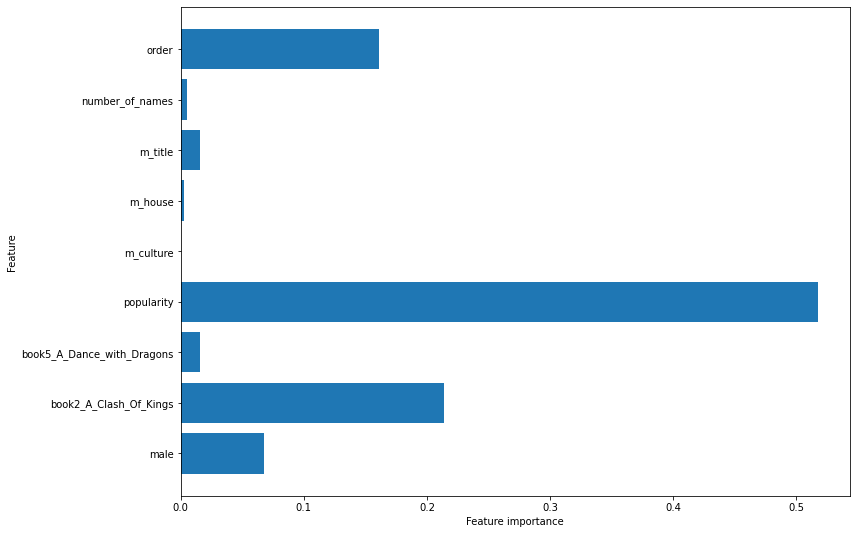

In [35]:
#Seeing how important each feature is
plot_feature_importances(tree_pruned_fit,
                         train = x_train,
                         export = False)

In [36]:
#Comparing the results before hypertuning
print(f"""
Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      {logreg_auc_score}         {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Full Tree     {full_tree_auc_score}           {full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp}
Pruned Tree   {pruned_tree_auc_score}         {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
""")


#Creating new dictionary with these results
model_performance = {
    
    'Model Name'    : ['Logistic', 'Full Tree', 'Pruned Tree'],
           
    'AUC Score' : [logreg_auc_score, full_tree_auc_score, pruned_tree_auc_score],
    
    'Training Accuracy' : [logreg_train_score, full_tree_train_score,
                           pruned_tree_train_score],
           
    'Testing Accuracy'  : [logreg_test_score, full_tree_test_score,
                           pruned_tree_test_score],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp)]}


#Creating data frame from this
model_performance = pd.DataFrame(model_performance)


#Sending model to excel
#model_performance.to_excel('./classification_model_performance.xlsx',
            #               index = False)


Model         AUC Score      TN, FP, FN, TP
-----         ---------      --------------
Logistic      0.619         (16, 34, 11, 123)
Full Tree     0.6954           (27, 23, 20, 114)
Pruned Tree   0.6766         (24, 26, 17, 117)



Hyperparameter tuning for the model

In [37]:
#Train/test split
got_data   =  got.loc[ : , candidate_dict['logit_sig']] #X variable
got_target =  got.loc[ : , 'isAlive'] #Y Variables


#Train/test split
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            random_state = 219,
            test_size    = 0.10,
            stratify     = got_target)

In [38]:
#New Hyperparameter
criterion_range = ['gini', 'entropy']
splitter_range  = ['best', 'random']
depth_range     = np.arange(1, 25, 1)
leaf_range      = np.arange(1, 100, 1)


#Creating hyperparamter grid
param_grid = {'criterion'        : criterion_range,
              'splitter'         : splitter_range,
              'max_depth'        : depth_range,
              'min_samples_leaf' : leaf_range}


# Starting the model
tuned_tree = DecisionTreeClassifier(random_state = 219)


#Using RandomizedSearchCV
tuned_tree_cv = RandomizedSearchCV(estimator             = tuned_tree,
                                   param_distributions   = param_grid,
                                   cv                    = 3,
                                   n_iter                = 1000,
                                   random_state          = 219, #Sample size
                                   scoring = make_scorer(roc_auc_score,
                                             needs_threshold = False)) 

#Fitting the data
tuned_tree_cv.fit(got_data, got_target)


#Priting the results with best parameter
print("Tuned Parameters  :", tuned_tree_cv.best_params_)
print("Tuned Training AUC:", tuned_tree_cv.best_score_.round(4))

Tuned Parameters  : {'splitter': 'best', 'min_samples_leaf': 92, 'max_depth': 2, 'criterion': 'entropy'}
Tuned Training AUC: 0.652


In [39]:
#Hypertuning for Decision tree
tree_tuned = DecisionTreeClassifier(splitter         = 'random',
                                    min_samples_leaf = 3, #Min
                                    max_depth        = 8, #Max
                                    criterion        = 'gini', 
                                    random_state     = 219) #Sample Size


#Fitting the data
tree_tuned_fit = tree_tuned.fit(got_data, got_target)


#Predicting the data
tree_tuned_pred = tree_tuned.predict(x_test)


#Scoring the results
print('Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))

#Saving scores
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy

#Printing the gap in absolute value. We want the gap to be lower than 0.05
train_test_gap = abs(tree_tuned_train_score - tree_tuned_test_score).round(4)

#saving the auc score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                       y_score = tree_tuned_pred).round(4) # auc

print('Train-Test Gap:', abs(tree_tuned_train_score - tree_tuned_test_score).round(4))


Training ACCURACY: 0.8154
Testing  ACCURACY: 0.8315
AUC Score        : 0.7276
Train-Test Gap: 0.0161


In [40]:
#Confusion matrix
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


#Printing the results
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")


True Negatives : 25
False Positives: 25
False Negatives: 6
True Positives : 128



In [41]:
# declaring model performance objects
tree_train_acc = tree_tuned.score(x_train, y_train).round(4)
tree_test_acc  = tree_tuned.score(x_test, y_test).round(4)
tree_auc       = roc_auc_score(y_true  = y_test,
                              y_score = tree_tuned_pred).round(4)


# appending to model_performance
model_performance = model_performance.append(
                          {'Model Name'        : 'Tuned Tree',
                           'Training Accuracy' : tree_train_acc,
                           'Testing Accuracy'  : tree_test_acc,
                           'AUC Score'         : tree_auc,
                           'Confusion Matrix'  : (tuned_tree_tn,
                                                  tuned_tree_fp,
                                                  tuned_tree_fn,
                                                  tuned_tree_tp)},
                           ignore_index = True)


# checking the results
model_performance

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic,0.6190,0.7524,0.7554,"(16, 34, 11, 123)"
1,Full Tree,0.6954,1.0000,0.7663,"(27, 23, 20, 114)"
2,Pruned Tree,0.6766,0.8075,0.7663,"(24, 26, 17, 117)"
3,Tuned Tree,0.7276,0.8154,0.8315,"(25, 25, 6, 128)"


In [42]:
#Looking at model with the best AUC score
model_performance.sort_values(by = 'AUC Score', ascending = False)

,Model Name,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
3,Tuned Tree,0.7276,0.8154,0.8315,"(25, 25, 6, 128)"
1,Full Tree,0.6954,1.0000,0.7663,"(27, 23, 20, 114)"
2,Pruned Tree,0.6766,0.8075,0.7663,"(24, 26, 17, 117)"
0,Logistic,0.6190,0.7524,0.7554,"(16, 34, 11, 123)"


In [43]:
#Selecting the best and final model which is Tuned Tree
print(f"""

FINAL MODEL:
Model Type: Tuned Tree 

Training Accruacy: {tree_tuned_train_score}
Testing Accruacy: {tree_tuned_test_score}
Train-Test Gap: {train_test_gap}
AUC Score: {tree_tuned_auc}

Confusion:
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")



FINAL MODEL:
Model Type: Tuned Tree 

Training Accruacy: 0.8154
Testing Accruacy: 0.8315
Train-Test Gap: 0.0161
AUC Score: 0.7276

Confusion:
True Negatives : 25
False Positives: 25
False Negatives: 6
True Positives : 128

